In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import DistilBertTokenizerFast,DistilBertForTokenClassification

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import zipfile
import os

In [5]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Yelp-dataset')

In [6]:
import zipfile
zip_ref=zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Yelp-dataset/Yelp.zip','r')
zip_ref.extractall('Yelp-dataset')
zip_ref.close()

In [7]:
train_path='/content/drive/MyDrive/Colab Notebooks/Yelp-dataset/Yelp-dataset/yelp_review_fine-grained_5_classes_csv/train.csv'
test_path='/content/drive/MyDrive/Colab Notebooks/Yelp-dataset/Yelp-dataset/yelp_review_fine-grained_5_classes_csv/test.csv'

In [8]:
train_df=pd.read_csv(train_path)
test_df=pd.read_csv(test_path)
train_df.head()

,class_index,review_text
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...


### **Data Preparation**

In [9]:
train_df=train_df.groupby(by='class_index',group_keys=False).apply(lambda x: x.sample(frac=0.05, random_state=0))

In [10]:
train_df.shape

(32500, 2)

In [11]:
bool=train_df.isnull().values.any()
if bool:
  print('There are some missing values')
else:
  print('No missing Values')
bool.sum()

No missing Values


0

In [12]:
train_df['class_index'].value_counts()

1    6500
2    6500
3    6500
4    6500
5    6500
Name: class_index, dtype: int64

In [13]:
test_df.shape

(50000, 2)

In [14]:
stars=['*','**','***','****','*****']

In [15]:
texts=[]
for i in range(5):
  texts.append(train_df[train_df['class_index']==i+1]['review_text'].reset_index())
  texts[i].drop(['index'],inplace=True,axis=1)


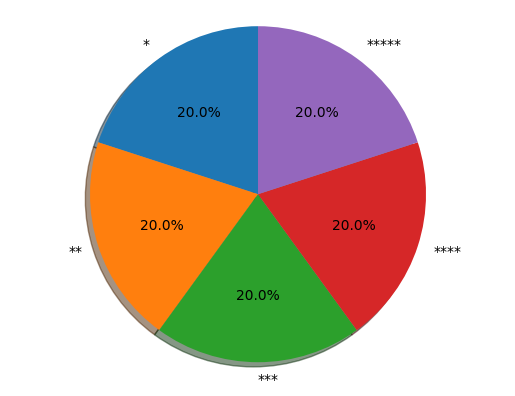

<Figure size 1500x1000 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
sizes = [len(texts[i]) for i in range(5)]
ax1.pie(sizes,labels=stars, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.figure( figsize=(15,10) )
plt.show()

In [17]:
for i in range(0,5):
    print('\033[1m{} star rewiew \033[0m \n'.format(i+1))
    print(texts[i]['review_text'][1], '\n')

1 star rewiew  

This place was the worst place I ever went to. I took my laptop in because it would not boot. I am a patient person so I gave them two weeks before calling and checking in. I was told they needed another week. So I called a week and a half later and was told they had no record of my laptop!! After sitting on the phone with the lady, she found my laptop (unorganized much?) She said someone would call me soon with information on it. No one called. Basically two months after taking it in, I went into the store and demanded my laptop. It was in the back somewhere buried but taken apart. Definitely not fixed at all. He tried to convince me to leave it because it was dangerous for the laptop to be handled dismantled, but I was having none of it. They even had the nerve to charge me! I paid the fee for the quote because it was the only way to get my laptop back.\n\nBTW, I am referring to the place in MONONA, just because my profile said I was in Arizona for awhile does not me

In [18]:
train_df=train_df.sample(frac=1)

In [19]:
train_df.shape

(32500, 2)

In [20]:
train_df=train_df.reset_index()
train_df.drop(['index'],axis=1,inplace=True)


In [21]:
train_df

,class_index,review_text
0,1,"Food is ok, but the service is too bad, refer ..."
1,4,Ok went here for my cheat meal.... Love their ...
2,5,This place is the quintessential Jewish steakh...
3,4,i lived in san luis obispo for a few months an...
4,5,Excellent shrimp Charlotte a gumbo...very cute...
...,...,...
32495,4,This is my favorite Chinese restaurant in town...
32496,2,Some really outstanding flavors and experiment...
32497,5,We grabbed a few drinks at this bar and I am g...
32498,4,This place is very good. Great. Just two very ...


In [22]:
train_df.dtypes

class_index     int64
review_text    object
dtype: object

In [23]:
#train_df=pd.get_dummies(train_df,columns=['class_index'],drop_first=False)

In [24]:
#train_df

In [25]:
#train_df.rename(columns={'class_index_1': '1-star','class_index_2': '2-star','class_index_3': '3-star','class_index_4': '4-star','class_index_5': '5-star'},inplace=True)

In [26]:
#train_df.columns


In [27]:
#target_list=['1-star', '2-star', '3-star', '4-star', '5-star']

In [28]:
#train_df[target_list].values

In [29]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 1e-05

In [30]:

#train_size = 0.8
#train_val = train_df.sample(frac=train_size, random_state=200).reset_index(drop=True)
#val_df = train_df.drop(train_val.index).reset_index(drop=True)
X_train=train_df

In [31]:
X_train.shape

(32500, 2)

In [32]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [33]:
X_input_ids=np.zeros((len(X_train),512))
X_attention_mask=np.zeros((len(X_train),512))
X_token_ids= np.zeros((len(X_train),512))

In [34]:
X_input_ids.shape

(32500, 512)

In [35]:
def generate_Dataset(df, ids, masks, tok, token):
  for i,text in tqdm (enumerate(df['review_text'])):
    tokenized_text=tokenizer.encode_plus(
    text,
    add_special_tokens=True,     
    max_length=512, 
    truncation=True, 
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids=True)
    ids[i,:] = tokenized_text.input_ids 
    masks[i,:] = tokenized_text.attention_mask
    tok[i,:] =tokenized_text.token_type_ids
  return ids,masks,tok


In [36]:
X_input_ids, X_attention_mask, X_token_ids = generate_Dataset(X_train, X_input_ids, X_attention_mask,X_token_ids, tokenizer)

0it [00:00, ?it/s]

In [37]:
labels = pd.get_dummies(X_train,columns=['class_index'],drop_first=False)
labels.head()

,review_text,class_index_1,class_index_2,class_index_3,class_index_4,class_index_5
0,"Food is ok, but the service is too bad, refer ...",1,0,0,0,0
1,Ok went here for my cheat meal.... Love their ...,0,0,0,1,0
2,This place is the quintessential Jewish steakh...,0,0,0,0,1
3,i lived in san luis obispo for a few months an...,0,0,0,1,0
4,Excellent shrimp Charlotte a gumbo...very cute...,0,0,0,0,1


In [38]:
labels.rename(columns={'class_index_1': '1-star','class_index_2': '2-star','class_index_3': '3-star','class_index_4': '4-star','class_index_5': '5-star'},inplace=True)

In [39]:
labels.columns

Index(['review_text', '1-star', '2-star', '3-star', '4-star', '5-star'], dtype='object')

In [40]:
target_list=['1-star', '2-star', '3-star', '4-star', '5-star']

In [41]:
label_array=np.array(labels[target_list].values).astype('float64')
label_array.dtype

dtype('float64')

In [42]:
X_input_ids.dtype

dtype('float64')

In [43]:
# creating a data pipeline using tensorflow dataset utility, and creating batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attention_mask, X_token_ids, label_array))
dataset.take(1) # one sample data

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [44]:
def RatingDatasetMapFunction(input_ids, attention_mask, token_id, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_id
    }, labels

In [45]:
dataset = dataset.map(RatingDatasetMapFunction) # converting to required format for tensorflow dataset 

In [46]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'token_type_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [47]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [48]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'token_type_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [49]:
p = 0.8
train_size = int((len(X_train)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

In [50]:
train_size

1624

In [51]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

### **Model**

In [52]:
from transformers import TFDistilBertForSequenceClassification

In [53]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased') # bert base model with pretrained weights

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [54]:
!nvidia-smi

Wed May 10 10:09:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |   1591MiB / 15360MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [55]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))




Num GPUs Available:  1


In [56]:
# Check if GPU is available

device=tf.device('GPU') if tf.config.list_physical_devices('GPU') else tf.device('CPU')

In [57]:
device

In [58]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')
bert_embds = model.distilbert(input_ids, attention_mask=attn_masks)
pooled_output = tf.keras.layers.GlobalAveragePooling1D()(bert_embds[0])
# 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(pooled_output)
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

Rating_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
Rating_model.summary()
print(bert_embds[0])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 distilbert (TFDistilBertMainLa  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 yer)                           ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 512, 768),                                                   
                                 hidden_states=None                                           

In [59]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-5,epsilon=1e-7)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [60]:
Rating_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [61]:
hist = Rating_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1624/1624 [==============================] - 1766s 1s/step - loss: 0.9780 - accuracy: 0.5656 - val_loss: 0.8389 - val_accuracy: 0.6239
Epoch 2/3
1624/1624 [==============================] - 1669s 1s/step - loss: 0.8195 - accuracy: 0.6388 - val_loss: 0.7245 - val_accuracy: 0.6989
Epoch 3/3
1624/1624 [==============================] - 1657s 1s/step - loss: 0.7217 - accuracy: 0.6861 - val_loss: 0.6444 - val_accuracy: 0.7328


In [64]:
Rating_model.save('Rating_model')

### **Prediction**

In [65]:
Rating_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Yelp-dataset/Rating_model')

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=512, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=target_list):
    probs = model.predict(processed_data)[0]
    return classes[np.argmax(probs)]

In [68]:
input_text = input('Enter Restraunt review here: ')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(Rating_model, processed_data=processed_data)
print(f"Predicted Rating: {result}")

Enter Restraunt review here: I will give an average rating. Staff is really helpful
1/1 [==============================] - 0s 60ms/step
Predicted Sentiment: 3-star
